# Weekly Project: Image Classification with Transfer Learning


In [8]:
import kagglehub

path = kagglehub.dataset_download(
    "usman44m/bone-fracture-x-ray-dataset"
)

print(path)


Using Colab cache for faster access to the 'bone-fracture-x-ray-dataset' dataset.
/kaggle/input/bone-fracture-x-ray-dataset


In [2]:
!ls "/root/.cache/kagglehub/datasets/usman44m/bone-fracture-x-ray-dataset/versions/1"


Bone_Fracture_Dataset


## Imports

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import time

## Setup Device

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='2'></a>
##  Data Preparation


In [5]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [26]:
train_transform=transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean , std)
])

val_transform=transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean , std)
])


In [27]:
from torchvision import datasets
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def safe_pil_loader(path):#To make sure that the images are not courrpdted
    try:
        img = Image.open(path)
        return img.convert("RGB")
    except Exception:
        # return a dummy image instead of crashing
        return Image.new("RGB", (224, 224))

train_raw = datasets.ImageFolder(
    root="/kaggle/input/bone-fracture-x-ray-dataset/Bone_Fracture_Dataset/train",
    transform=train_transform,
    loader=safe_pil_loader
)
val_raw=datasets.ImageFolder(
    root="/kaggle/input/bone-fracture-x-ray-dataset/Bone_Fracture_Dataset/val",
    transform=val_transform,
    loader=safe_pil_loader
)

test_raw = datasets.ImageFolder(
    root="/kaggle/input/bone-fracture-x-ray-dataset/Bone_Fracture_Dataset/test",
    transform=val_transform,
    loader=safe_pil_loader
)

print("Classes:", train_raw.classes)
print("Train size:", len(train_raw), "Test size:", len(test_raw))



Classes: ['fractured', 'not fractured']
Train size: 9246 Test size: 506


# DataLoader

In [28]:
train_loader = torch.utils.data.DataLoader(
    train_raw,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader= torch.utils.data.DataLoader(
    train_raw,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

teat_loader=torch.utils.data.DataLoader(
    test_raw,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# visualizing the data

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_transformed_images(dataset, batch_size=9):


    images, labels = next(iter(train_loader))

    grid = torchvision.utils.make_grid(images, nrow=3)

    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")

    print("Labels:", labels)

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1])


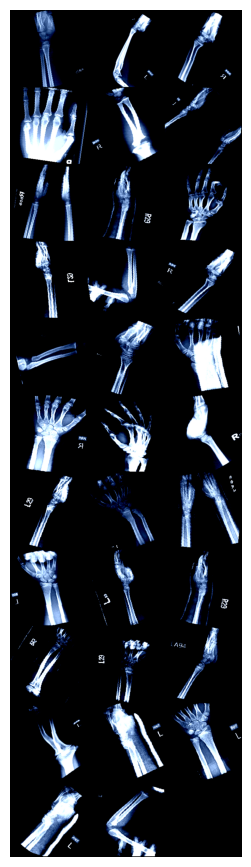

In [15]:
show_transformed_images(train_raw)

<a name='3'></a>
# Model Building



In [31]:
# Load pre-trained ResNet18
model_ft = models.resnet18(weights='DEFAULT')


print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# fine-tuning
In this I will be using partial-fine-tuning

In [32]:

for p in model_ft.parameters():
    p.requires_grad = False


for p in model_ft.layer4.parameters():
    p.requires_grad = True

for p in model_ft.fc.parameters():
    p.requires_grad = True

optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()


<a name='4'></a>
##  Training


In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):

        model.train()
        train_correct = train_total = 0
        train_loss = 0.0

        for image, label in train_loader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()

            outputs = model(image)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * image.size(0)
            preds = outputs.argmax(1)
            train_correct += (preds == label).sum().item()
            train_total += label.size(0)


        model.eval()
        val_correct = val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)
                outputs = model(image)
                loss = criterion(outputs, label)

                val_loss += loss.item() * image.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == label).sum().item()
                val_total += label.size(0)

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Acc {train_acc:.4f} Loss {train_loss/train_total:.4f} | "
              f"Val Acc {val_acc:.4f} Loss {val_loss/val_total:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    print("Best Val Acc:", best_acc)
    return model


In [34]:
import PIL.ImageFile
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

model_ft.to(device)
model_ft = train_model(model_ft,train_loader, val_loader,criterion, optimizer_ft, num_epochs=10)

Epoch 1/10 | Train Acc 0.8952 Loss 0.7967 | Val Acc 0.9908 Loss 0.0309
Epoch 2/10 | Train Acc 0.9913 Loss 0.0314 | Val Acc 0.9966 Loss 0.0113
Epoch 3/10 | Train Acc 0.9935 Loss 0.0203 | Val Acc 0.9983 Loss 0.0061
Epoch 4/10 | Train Acc 0.9961 Loss 0.0136 | Val Acc 0.9978 Loss 0.0063
Epoch 5/10 | Train Acc 0.9958 Loss 0.0138 | Val Acc 0.9995 Loss 0.0033
Epoch 6/10 | Train Acc 0.9935 Loss 0.0191 | Val Acc 0.9986 Loss 0.0031
Epoch 7/10 | Train Acc 0.9984 Loss 0.0047 | Val Acc 0.9996 Loss 0.0013
Epoch 8/10 | Train Acc 0.9964 Loss 0.0110 | Val Acc 0.9987 Loss 0.0048
Epoch 9/10 | Train Acc 0.9973 Loss 0.0081 | Val Acc 0.9995 Loss 0.0016
Epoch 10/10 | Train Acc 0.9976 Loss 0.0074 | Val Acc 0.9989 Loss 0.0035
Best Val Acc: 0.9995673804888601


<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [35]:
model_ft.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for image, label in teat_loader:
        image, label = image.to(device), label.to(device)
        outputs = model_ft(image)
        preds = outputs.argmax(1)
        test_correct += (preds == label).sum().item()
        test_total += label.size(0)

test_acc = test_correct / test_total
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9861660079051383


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds = []
all_labels = []

model_ft.eval()
with torch.no_grad():
    for image, label in teat_loader:
        image = image.to(device)
        outputs = model_ft(image)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(label.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nReport:\n", classification_report(all_labels, all_preds, digits=4))


Confusion Matrix:
 [[234   4]
 [  3 265]]

Report:
               precision    recall  f1-score   support

           0     0.9873    0.9832    0.9853       238
           1     0.9851    0.9888    0.9870       268

    accuracy                         0.9862       506
   macro avg     0.9862    0.9860    0.9861       506
weighted avg     0.9862    0.9862    0.9862       506

